# Final Project B: Retail
### by Harry Zarcadoolas & Gabe De Brito
#### IMPORTANT NOTE: The project description assumes the data is browsing data, but it is transactional data. So, in some sections different analysis was performed. For example, you can't see how likely a customer is to buy a product because every customer has a transaction because it'd be 100%. Instead, we analyze the transactions themselves.

In [1]:
!where python

c:\Users\harry\anaconda3\envs\env-final-project\python.exe
C:\Program Files\Python312\python.exe
C:\Users\harry\AppData\Local\Microsoft\WindowsApps\python.exe
C:\msys64\ucrt64\bin\python.exe
C:\Users\harry\anaconda3\python.exe


#### Library Imports

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
import datetime as dt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from mlxtend.frequent_patterns import apriori, association_rules

# 1. Data Exploration

In [ ]:
# load data
original_data = pd.read_excel('https://archive.ics.uci.edu/ml/machine-learning-databases/00502/online_retail_II.xlsx')

In [ ]:
# verify attributes
print("Initial column names:\n", original_data.columns)

Initial column names:
 Index(['Invoice', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'Price', 'Customer ID', 'Country'],
      dtype='object')


## Data Cleaning and Preprocessing

In [ ]:
# copy data to avoid modifying original data accidentally
data_copy = original_data.copy()

# adjust column names
data_copy.rename(columns={
    'Invoice': 'InvoiceNo',
    'Price': 'UnitPrice',
    'Customer ID': 'CustomerID'
}, inplace=True)

# remove missing values
print("Missing values before cleaning:\n", data_copy.isnull().sum(), "\n")
if data_copy.isnull().sum().sum() == 0:
    print('\nNo missing values')
else:
    print('Missing values found')
    data_copy = data_copy.dropna()
    print('Missing values removed')
    print("Missing values after cleaning for confirmation:\n", data_copy.isnull().sum())

# remove negative or zero quantities and prices
print("\nRemoving negative quantities and prices...")
data_copy = data_copy[(data_copy['Quantity'] > 0) & (data_copy['UnitPrice'] > 0)]

# add a total price column
print("Creating TotalPrice column by multiplying Quantity and UnitPrice...")
data_copy['TotalPrice'] = data_copy['Quantity'] * data_copy['UnitPrice']

# use InvoiceDate column to get time-based features
print("Extracting time-based features from InvoiceDate column...")
data_copy['InvoiceDate'] = pd.to_datetime(data_copy['InvoiceDate'])

print("Tasks Completed")

Missing values before cleaning:
 InvoiceNo           0
StockCode           0
Description      2928
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     107927
Country             0
dtype: int64 

Missing values found
Missing values removed
Missing values after cleaning for confirmation:
 InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

Removing negative quantities and prices...
Creating TotalPrice column by multiplying Quantity and UnitPrice...
Extracting time-based features from InvoiceDate column...
Tasks Completed


### Confirm columns

In [7]:
print(data_copy.info())

<class 'pandas.core.frame.DataFrame'>
Index: 407664 entries, 0 to 525460
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    407664 non-null  object        
 1   StockCode    407664 non-null  object        
 2   Description  407664 non-null  object        
 3   Quantity     407664 non-null  int64         
 4   InvoiceDate  407664 non-null  datetime64[ns]
 5   UnitPrice    407664 non-null  float64       
 6   CustomerID   407664 non-null  float64       
 7   Country      407664 non-null  object        
 8   TotalPrice   407664 non-null  float64       
dtypes: datetime64[ns](1), float64(3), int64(1), object(4)
memory usage: 31.1+ MB
None


### See where customers are shopping from to target consumer locations

C:\Users\harry\AppData\Local\Temp\ipykernel_13884\2113233930.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=country_counts.index, x=country_counts.values, palette='viridis')


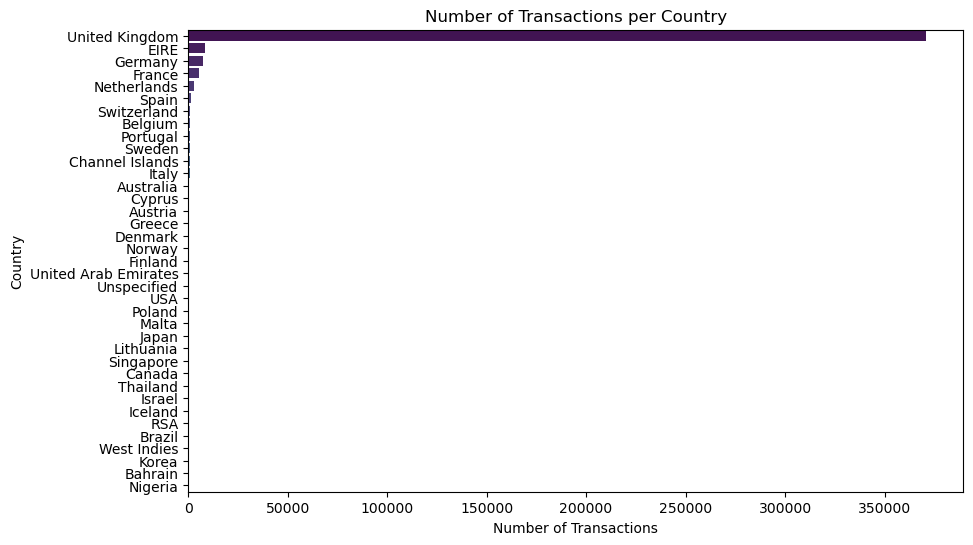

In [ ]:
country_counts = data_copy['Country'].value_counts()
plt.figure(figsize=(10, 6))
sns.barplot(y=country_counts.index, x=country_counts.values, palette='viridis')
plt.title('Number of Transactions per Country')
plt.xlabel('Number of Transactions')
plt.ylabel('Country')
plt.show()

del country_counts

This plot shows customers are centralized in the UK with some other mainly European outliers.

## View monthly sales trends to see months of most revenue

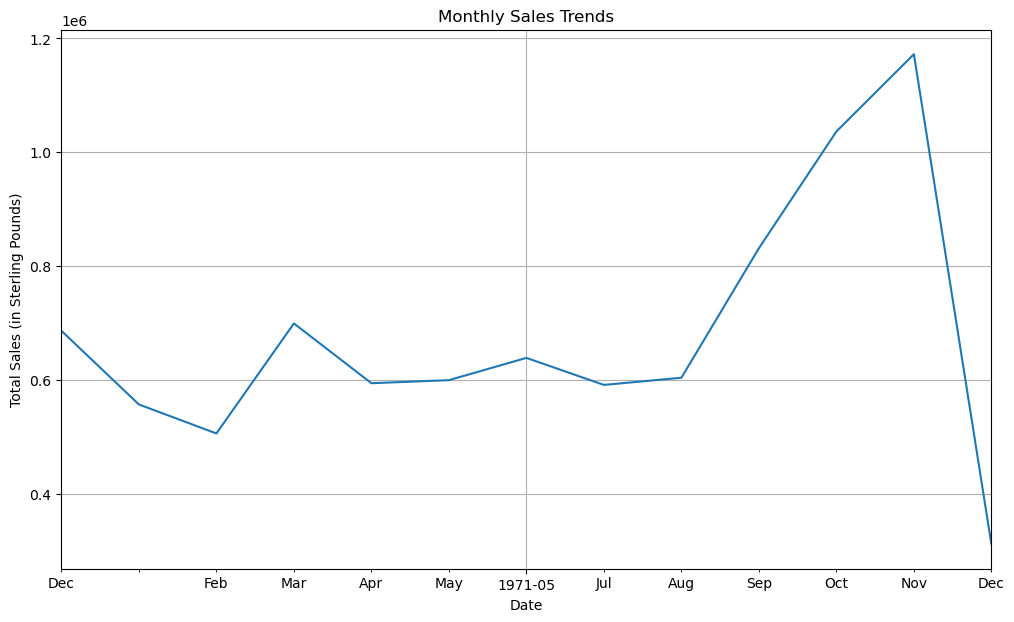

In [ ]:
# index the DataFrame with InvoiceDate
data_copy.set_index('InvoiceDate', inplace=True)

monthly_sales = data_copy['TotalPrice'].resample('ME').sum()

# plot trends in monthly sales
plt.figure(figsize=(12, 7))
monthly_sales.plot()
plt.title('Monthly Sales Trends')
plt.xlabel('Date')
plt.ylabel('Total Sales (in Sterling Pounds)')
plt.grid(True)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())

plt.show()

# reset the index to avoid issues with later analysis
data_copy.reset_index(inplace=True)

del monthly_sales

The graph shows a jump in sales during early spring followed by a large spike come fall.

## Items that generate the most revenue and total revenue

In [ ]:
item_revenue = data_copy.groupby('Description')['TotalPrice'].sum()
top_items = item_revenue.sort_values(ascending=False)

# percentage of total revenue for each item
total_revenue = top_items.sum()
top_items_percentage = (top_items / total_revenue) * 100

print("Total revenue: (sterling pounds) £", total_revenue, '\n')

# combine into a single df
top_items_df = pd.DataFrame({'Revenue': top_items, 'Percentage': top_items_percentage})

print("Top 10 items generating the most revenue (in £):\n", top_items_df.head(10))

del item_revenue, top_items, top_items_percentage, top_items_df

Total revenue: (sterling pounds) £ 8832003.274 

Top 10 items generating the most revenue (in £):
                                        Revenue  Percentage
Description                                               
WHITE HANGING HEART T-LIGHT HOLDER   151624.31    1.716760
REGENCY CAKESTAND 3 TIER             143893.35    1.629227
Manual                                98560.64    1.115949
ASSORTED COLOUR BIRD ORNAMENT         70493.83    0.798164
JUMBO BAG RED RETROSPOT               51759.30    0.586043
POSTAGE                               48741.08    0.551869
ROTATING SILVER ANGELS T-LIGHT HLDR   40186.65    0.455012
PAPER CHAIN KIT 50'S CHRISTMAS        36933.50    0.418178
PARTY BUNTING                         35035.90    0.396693
EDWARDIAN PARASOL NATURAL             34044.75    0.385470


## Identifying which time of the day accounts for the most revenue generated

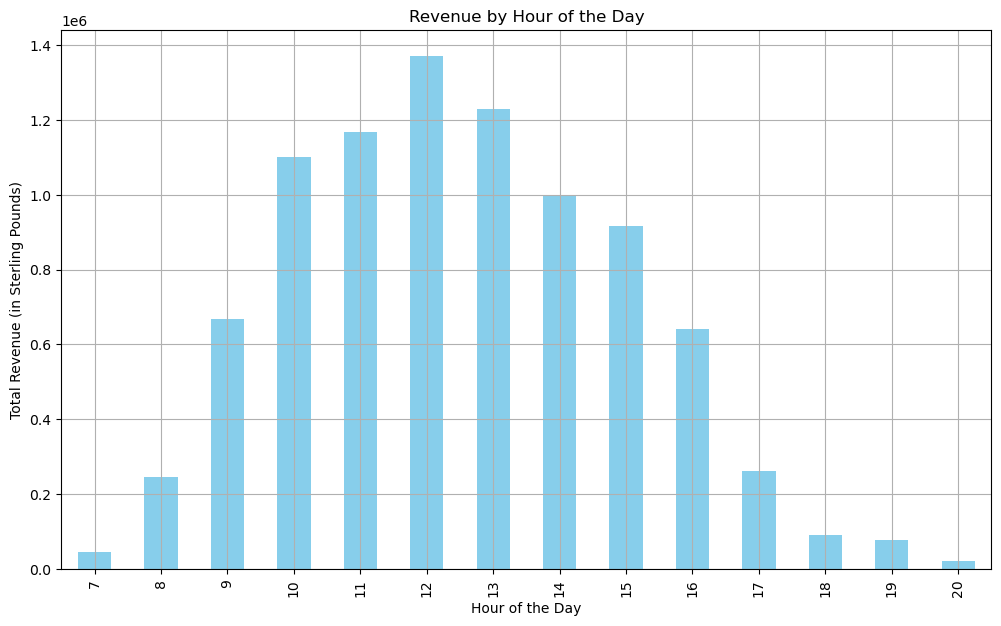

In [ ]:
# extract hour information
data_copy['Hour'] = data_copy['InvoiceDate'].dt.hour
hourly_revenue = data_copy.groupby(data_copy['InvoiceDate'].dt.hour)['TotalPrice'].sum()

plt.figure(figsize=(12, 7))
hourly_revenue.plot(kind='bar', color='skyblue')
plt.title('Revenue by Hour of the Day')
plt.xlabel('Hour of the Day')
plt.ylabel('Total Revenue (in Sterling Pounds)')
plt.grid(True)
plt.show()

del hourly_revenue

The graph shows a typical bell-distribution curve with the time that most purchasing happening at 12 noon and tailing down towards early morning and late at night.

## Identifying which day of the week accounts for the most revenue generated

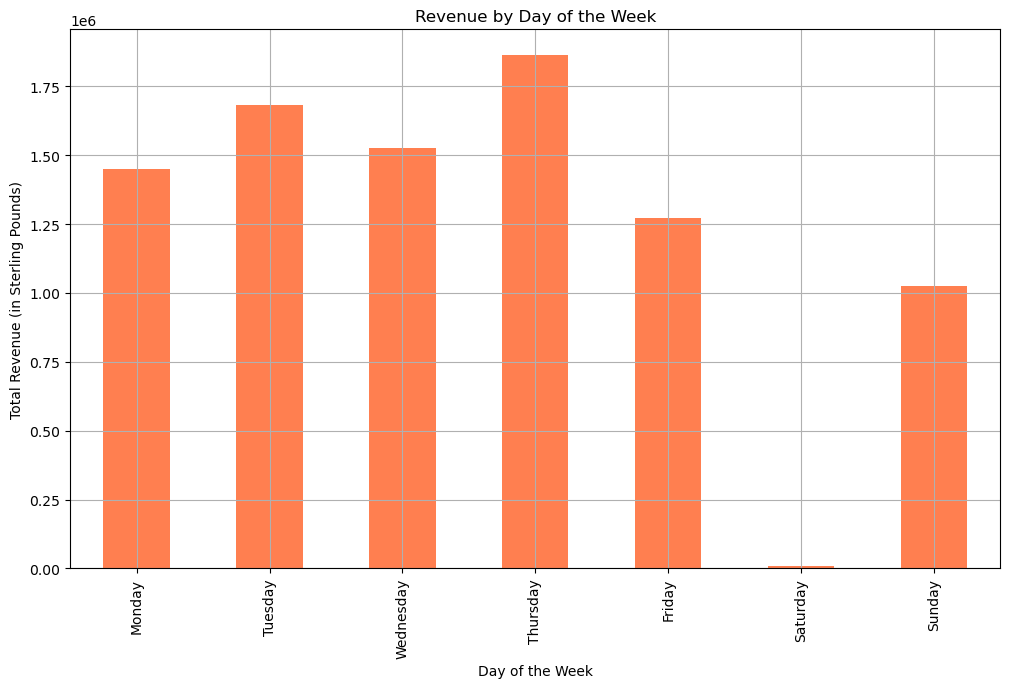

In [ ]:
# extract day of the week
data_copy['DayOfWeek'] = data_copy['InvoiceDate'].dt.day_name()

day_of_week_revenue = data_copy.copy()
day_of_week_revenue['DayOfWeek'] = day_of_week_revenue['InvoiceDate'].dt.day_name()
day_of_week_revenue = day_of_week_revenue.groupby('DayOfWeek')['TotalPrice'].sum()
day_of_week_revenue = day_of_week_revenue.reindex(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

# Plot the revenue by day of the week
plt.figure(figsize=(12, 7))
day_of_week_revenue.plot(kind='bar', color='coral')
plt.title('Revenue by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Total Revenue (in Sterling Pounds)')
plt.grid(True)
plt.show()

del day_of_week_revenue

From this graph, there appears to be purchased a fairly equal distribution amongst every day except Saturday. Saturday generates insignificant revenue which could be the result of the business not processing transaction on that day.

## Find how many customers are repeat customers

Number of repeat customers: 2893
Number of non-repeat customers: 1419


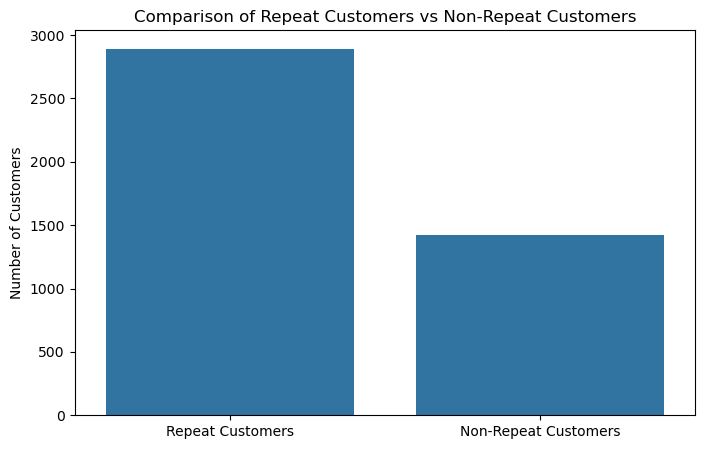

In [ ]:
# find unique customer IDs
customer_invoices = data_copy.groupby('CustomerID')['InvoiceNo'].nunique()

data_copy['RepeatCustomer'] = data_copy['CustomerID'].map(lambda x: 'Repeat' if customer_invoices[x] > 1 else 'Non-Repeat')
repeat_customers = customer_invoices[customer_invoices > 1].count()
non_repeat_customers = customer_invoices[customer_invoices == 1].count()
print(f"Number of repeat customers: {repeat_customers}")
print(f"Number of non-repeat customers: {non_repeat_customers}")

# plot repeat vs non-repeat customers
plt.figure(figsize=(8, 5))
sns.barplot(x=['Repeat Customers', 'Non-Repeat Customers'], y=[repeat_customers, non_repeat_customers])
plt.title('Comparison of Repeat Customers vs Non-Repeat Customers')
plt.ylabel('Number of Customers')
plt.show()

del repeat_customers, non_repeat_customers

From the plot, a majority of customers are repeat customers. This indicates a strong customer base and customer loyalty

## Identify top customers, amount of revenue they bring in, and whether or not they are repeat customers

In [ ]:
customer_revenue = data_copy.groupby('CustomerID')['TotalPrice'].sum()
top_customers = customer_revenue.sort_values(ascending=False)
# top 10 customers by revenue
top_10_customers = top_customers.head(10)

# see if the customers are repeat or not and how much money they bring in
top_10_customers_repeat_status = customer_invoices[top_10_customers.index].apply(lambda x: 'Repeat' if x > 1 else 'Non-Repeat')
top_10_customers_percentage = (top_10_customers / total_revenue) * 100
top_10_customers_df = pd.DataFrame({
    'Revenue': top_10_customers,
    'Percentage of Total Revenue': top_10_customers_percentage,
    'Repeat Status': top_10_customers_repeat_status
})

print("Top 10 customers by revenue, their repeat status, and percentage of total revenue:\n")
print(top_10_customers_df)

del top_10_customers, top_10_customers_repeat_status, top_10_customers_percentage, top_customers, top_10_customers_df

Top 10 customers by revenue, their repeat status, and percentage of total revenue:

              Revenue  Percentage of Total Revenue Repeat Status
CustomerID                                                      
18102.0     349164.35                     3.953399        Repeat
14646.0     248396.50                     2.812459        Repeat
14156.0     196566.74                     2.225619        Repeat
14911.0     152147.57                     1.722685        Repeat
13694.0     131443.19                     1.488260        Repeat
17511.0      84541.17                     0.957214        Repeat
15061.0      83284.38                     0.942984        Repeat
16684.0      80489.21                     0.911336        Repeat
16754.0      65500.07                     0.741622        Repeat
17949.0      60117.60                     0.680679        Repeat


# 2. Customer Segmentation (Clustering)
## Recency, Frequency, and Monetary (RFM) clustering analysis using k-means

Cluster
0    2930
1    1030
4     334
2      14
3       4
Name: count, dtype: int64


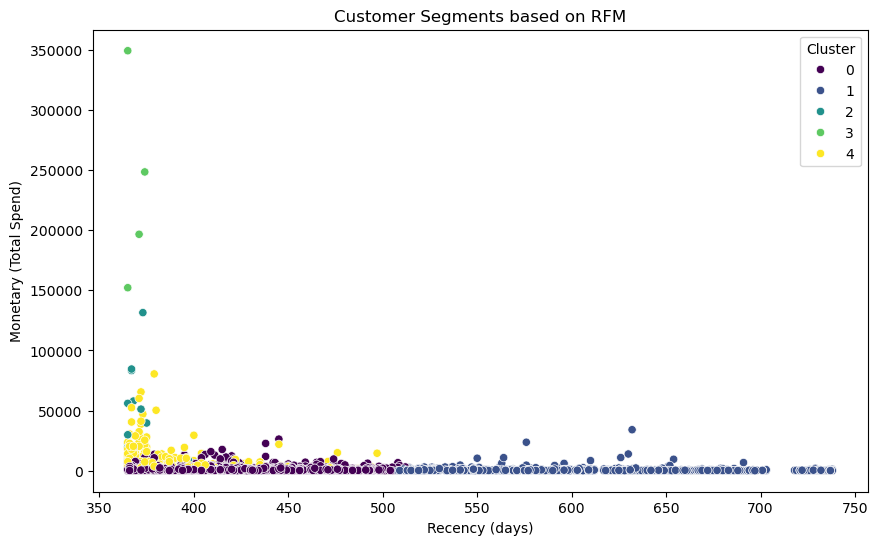

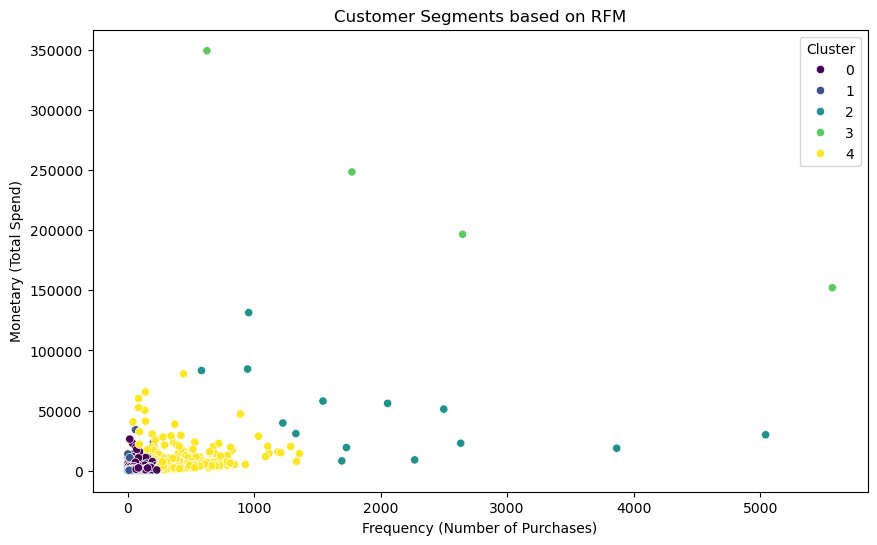

In [ ]:
# assume last date is the last day a transaction was made
current_date = dt.datetime(2011, 12, 10)

rfm = data_copy.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (current_date - x.max()).days,
    'InvoiceNo': 'count',
    'TotalPrice': 'sum'
}).reset_index()

rfm.columns = ['CustomerID', 'Recency', 'Frequency', 'Monetary']

# starndize the RFM metrics
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm[['Recency', 'Frequency', 'Monetary']])

# k-Means clustering
kmeans = KMeans(n_clusters=5, random_state=42)
rfm['Cluster'] = kmeans.fit_predict(rfm_scaled)
print(rfm['Cluster'].value_counts())

plt.figure(figsize=(10, 6))
sns.scatterplot(x='Recency', y='Monetary', hue='Cluster', data=rfm, palette='viridis')
plt.title('Customer Segments based on RFM')
plt.xlabel('Recency (days)')
plt.ylabel('Monetary (Total Spend)')
plt.legend(title='Cluster')
plt.show()

plt.figure(figsize=(10, 6))
sns.scatterplot(x='Frequency', y='Monetary', hue='Cluster', data=rfm, palette='viridis')
plt.title('Customer Segments based on RFM')
plt.xlabel('Frequency (Number of Purchases)')
plt.ylabel('Monetary (Total Spend)')
plt.legend(title='Cluster')
plt.show()

del rfm, rfm_scaled, scaler, kmeans, current_date

The RFM clustering shows that recency does seem to play a role in the total spend of a customer, with a higher spend closer with a lower reeceny and some small jumps in monetary spend at certain intervals being 440 days and in between 570-630 days.

### See if there are any potential patterns based on time of purchase of customers

C:\Users\harry\AppData\Local\Temp\ipykernel_13884\659647488.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  time_features['DayOfWeek'] = time_features['DayOfWeek'].map({


Cluster counts based on DayOfWeek:
 Cluster_DayOfWeek
0    2171
4    1443
1     677
2      18
3       3
Name: count, dtype: int64
Cluster counts based on Month:
 Cluster_Month
1    2175
2    1079
0    1038
4      17
3       3
Name: count, dtype: int64
Cluster counts based on Hour:
 Cluster_Hour
0    2199
2    1735
1     358
4      17
3       3
Name: count, dtype: int64


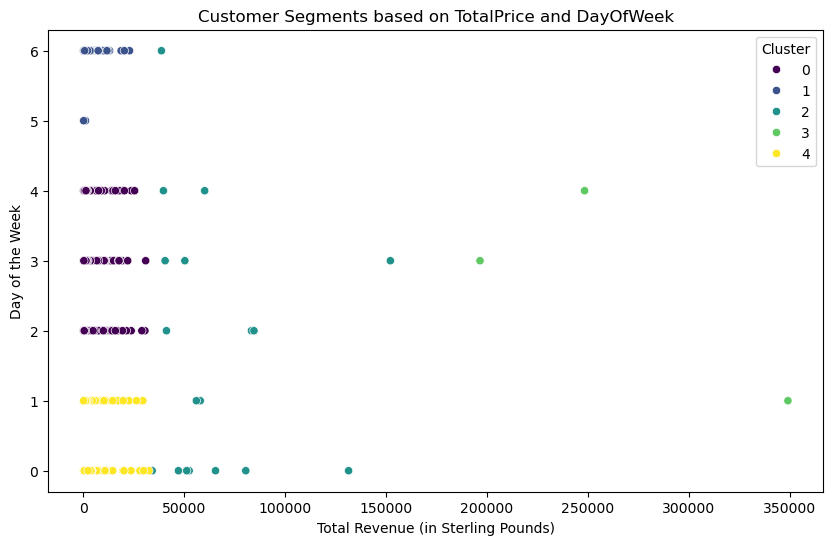

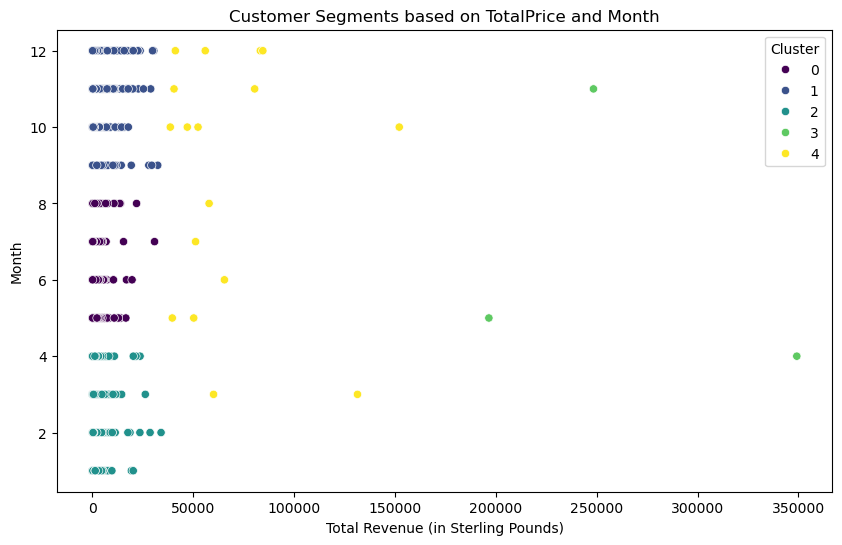

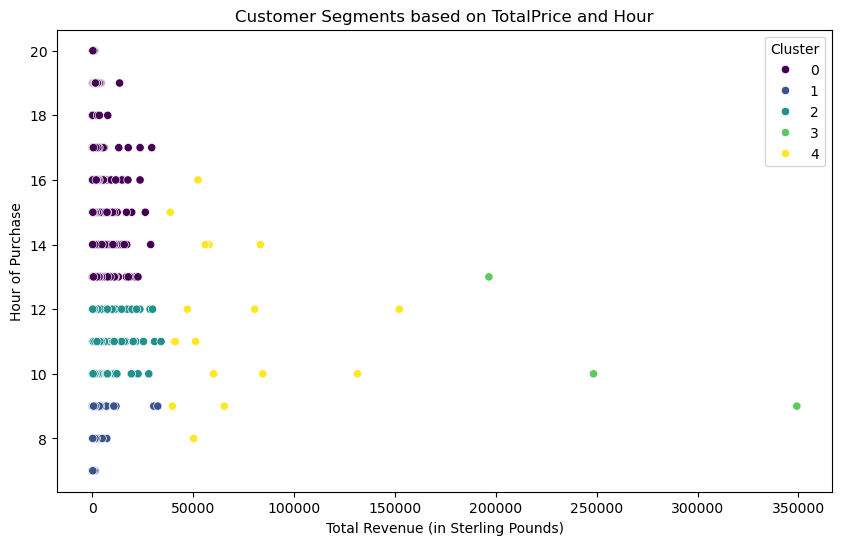

In [ ]:
# extract month and make it a column in data
data_copy['Month'] = data_copy['InvoiceDate'].dt.month


time_features = data_copy[['CustomerID', 'TotalPrice', 'DayOfWeek', 'Month', 'Hour']]
time_features['DayOfWeek'] = time_features['DayOfWeek'].map({
    'Monday': 0, 'Tuesday': 1, 'Wednesday': 2, 'Thursday': 3, 'Friday': 4, 'Saturday': 5, 'Sunday': 6
})

# group by customer IDs
time_features_agg = time_features.groupby('CustomerID').agg({
    'TotalPrice': 'sum',
    'DayOfWeek': lambda x: x.mode()[0],
    'Month': lambda x: x.mode()[0],
    'Hour': lambda x: x.mode()[0]
}).reset_index()

scaler = StandardScaler()

# different clustering methods below
# clustering based on TotalPrice and DayOfWeek
features_dayofweek = time_features_agg[['TotalPrice', 'DayOfWeek']]
features_dayofweek_scaled = scaler.fit_transform(features_dayofweek)
kmeans_dayofweek = KMeans(n_clusters=5, random_state=42)
time_features_agg['Cluster_DayOfWeek'] = kmeans_dayofweek.fit_predict(features_dayofweek_scaled)

# clustering based on TotalPrice and Month
features_month = time_features_agg[['TotalPrice', 'Month']]
features_month_scaled = scaler.fit_transform(features_month)
kmeans_month = KMeans(n_clusters=5, random_state=42)
time_features_agg['Cluster_Month'] = kmeans_month.fit_predict(features_month_scaled)

# clustering based on TotalPrice and Hour
features_hour = time_features_agg[['TotalPrice', 'Hour']]
features_hour_scaled = scaler.fit_transform(features_hour)
kmeans_hour = KMeans(n_clusters=5, random_state=42)
time_features_agg['Cluster_Hour'] = kmeans_hour.fit_predict(features_hour_scaled)


print("Cluster counts based on DayOfWeek:\n", time_features_agg['Cluster_DayOfWeek'].value_counts())
print("Cluster counts based on Month:\n", time_features_agg['Cluster_Month'].value_counts())
print("Cluster counts based on Hour:\n", time_features_agg['Cluster_Hour'].value_counts())
plt.figure(figsize=(10, 6))
sns.scatterplot(x='TotalPrice', y='DayOfWeek', hue='Cluster_DayOfWeek', data=time_features_agg, palette='viridis')
plt.title('Customer Segments based on TotalPrice and DayOfWeek')
plt.xlabel('Total Revenue (in Sterling Pounds)')
plt.ylabel('Day of the Week')
plt.legend(title='Cluster')
plt.show()

plt.figure(figsize=(10, 6))
sns.scatterplot(x='TotalPrice', y='Month', hue='Cluster_Month', data=time_features_agg, palette='viridis')
plt.title('Customer Segments based on TotalPrice and Month')
plt.xlabel('Total Revenue (in Sterling Pounds)')
plt.ylabel('Month')
plt.legend(title='Cluster')
plt.show()

plt.figure(figsize=(10, 6))
sns.scatterplot(x='TotalPrice', y='Hour', hue='Cluster_Hour', data=time_features_agg, palette='viridis')
plt.title('Customer Segments based on TotalPrice and Hour')
plt.xlabel('Total Revenue (in Sterling Pounds)')
plt.ylabel('Hour of Purchase')
plt.legend(title='Cluster')
plt.show()

del time_features, time_features_agg, features_dayofweek, features_dayofweek_scaled, kmeans_dayofweek
del features_month, features_month_scaled, kmeans_month
del features_hour, features_hour_scaled, kmeans_hour

The lack of clearly-defined clusters based on k-means using customer metrics of when they purchased compared to their total revenue implies that individual customers collectively are not prone to buying more based on time of purchase.

# 3. Customer Purchase Prediction
#### IMORTANT: This is the part of the project description that is most affected by the misinterpretation of the data. Since all customers in the transaction data made a purchase, there is no need to analyze where certain habits will lead to a purchase
#### ADAPTION: Instead of whether or not they will purchase, if they purchase over a certain amount

In [ ]:
# mean purchasing amount
mean_purchase_amount = customer_revenue.mean()

print(f"The mean purchasing amount each customer brings to the business is and will be the monetary threshold: £{mean_purchase_amount:.2f}")

del mean_purchase_amount

The mean purchasing amount each customer brings to the business is and will be the monetary threshold: £2048.24


In [ ]:
data_copy['DayOfWeek'] = data_copy['InvoiceDate'].dt.day_name()
data_copy['DayOfWeek'] = data_copy['DayOfWeek'].map({
    'Monday': 0, 'Tuesday': 1, 'Wednesday': 2, 'Thursday': 3, 'Friday': 4, 'Saturday': 5, 'Sunday': 6
})

data_copy['Month'] = data_copy['InvoiceDate'].dt.month
data_copy['Hour'] = data_copy['InvoiceDate'].dt.hour

# exctract customer features
customer_features = data_copy.groupby('CustomerID').agg({
    'TotalPrice': 'sum',
    'InvoiceNo': 'nunique',
    'Quantity': 'sum',
    'UnitPrice': 'mean',
    'Hour': 'mean',
    'DayOfWeek': lambda x: x.mode()[0],
    'Month': lambda x: x.mode()[0],
    'RepeatCustomer': lambda x: 1 if (x == 'Repeat').any() else 0
}).reset_index()

customer_features.rename(columns={
    'InvoiceNo': 'Frequency',
    'TotalPrice': 'TotalRevenue'
}, inplace=True)
# threshold is mean
threshold = customer_revenue.mean()

print("Columns in customer_features:\n", customer_features.columns, '\n\n')

customer_features['AboveThreshold'] = (customer_features['TotalRevenue'] > threshold).astype(int)
X = customer_features.drop(columns=['TotalRevenue', 'AboveThreshold'])
y = customer_features['AboveThreshold']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

# see performance
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

del threshold

Columns in customer_features:
 Index(['CustomerID', 'TotalRevenue', 'Frequency', 'Quantity', 'UnitPrice',
       'Hour', 'DayOfWeek', 'Month', 'RepeatCustomer'],
      dtype='object') 


Confusion Matrix:
 [[662  17]
 [ 24 160]]

Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.97      0.97       679
           1       0.90      0.87      0.89       184

    accuracy                           0.95       863
   macro avg       0.93      0.92      0.93       863
weighted avg       0.95      0.95      0.95       863



This data shows the results from runnning a random forest classification model to determine whether or not a customer will spend over a threshold amount, in this case above 2048 sterling pounds. Different customer features were displayed followed by the results including a confusion matrix and classification report showing accuracy. The matrix indicates a high percentage of true positives and true negatives and an overall high accuracy around 93 percent. So, high revenue generating customers can be targeted to induce higher transaction amounts through incentives.

# 4. Sales Forecasting (Regression)

Mean Squared Error: 11203948.456528123
R-squared: 0.5979818664272718


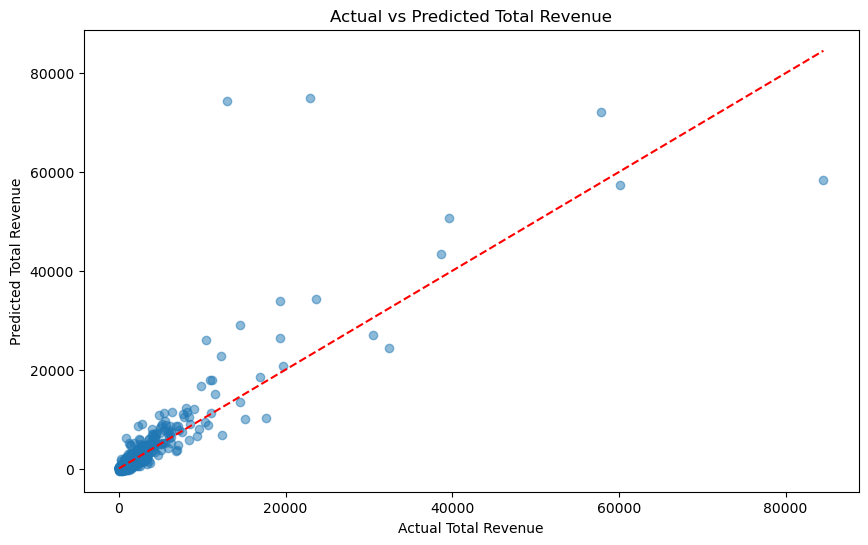

In [ ]:
X_reg = customer_features.drop(columns=['TotalRevenue', 'AboveThreshold'])
y_reg = customer_features['TotalRevenue']

# split data
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(X_reg, y_reg, test_size=0.2, random_state=42)

# linear regression
reg = LinearRegression()
reg.fit(X_train_reg, y_train_reg)
y_pred_reg = reg.predict(X_test_reg)
mse = mean_squared_error(y_test_reg, y_pred_reg)
r2 = r2_score(y_test_reg, y_pred_reg)
print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")

plt.figure(figsize=(10, 6))
plt.scatter(y_test_reg, y_pred_reg, alpha=0.5)
plt.plot([y_test_reg.min(), y_test_reg.max()], [y_test_reg.min(), y_test_reg.max()], 'r--')
plt.xlabel('Actual Total Revenue')
plt.ylabel('Predicted Total Revenue')
plt.title('Actual vs Predicted Total Revenue')
plt.show()

del X_reg, y_reg, X_train_reg, X_test_reg, y_train_reg, y_test_reg, reg, y_pred_reg, mse, r2

The plot shows that there is widespread variance when compraing predicted revenue versus actual and that the model is not able to make strong connections. It performance best when transaction totals are smaller.

# 5. Product Bundling (Association Rule Mining)

C:\Users\harry\AppData\Local\Temp\ipykernel_13884\3402053341.py:6: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  basket = basket.applymap(lambda x: 1 if x > 0 else 0)
c:\Users\harry\anaconda3\envs\env-final-project\lib\site-packages\mlxtend\frequent_patterns\fpcommon.py:109: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


Top 10 association rules:
                             antecedents                         consequents  \
53          (CHILDS GARDEN TROWEL PINK)        (CHILDS GARDEN TROWEL BLUE )   
52         (CHILDS GARDEN TROWEL BLUE )         (CHILDS GARDEN TROWEL PINK)   
368     (POPPY'S PLAYHOUSE LIVINGROOM )        (POPPY'S PLAYHOUSE BEDROOM )   
369        (POPPY'S PLAYHOUSE BEDROOM )     (POPPY'S PLAYHOUSE LIVINGROOM )   
371     (POPPY'S PLAYHOUSE LIVINGROOM )         (POPPY'S PLAYHOUSE KITCHEN)   
370         (POPPY'S PLAYHOUSE KITCHEN)     (POPPY'S PLAYHOUSE LIVINGROOM )   
367        (POPPY'S PLAYHOUSE BEDROOM )         (POPPY'S PLAYHOUSE KITCHEN)   
366         (POPPY'S PLAYHOUSE KITCHEN)        (POPPY'S PLAYHOUSE BEDROOM )   
111   (GREEN REGENCY TEACUP AND SAUCER)  (ROSES REGENCY TEACUP AND SAUCER )   
110  (ROSES REGENCY TEACUP AND SAUCER )   (GREEN REGENCY TEACUP AND SAUCER)   

     antecedent support  consequent support   support  confidence       lift  \
53             0.012023

C:\Users\harry\AppData\Local\Temp\ipykernel_13884\3402053341.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='lift', y='consequents', data=rules.head(10), palette='viridis')


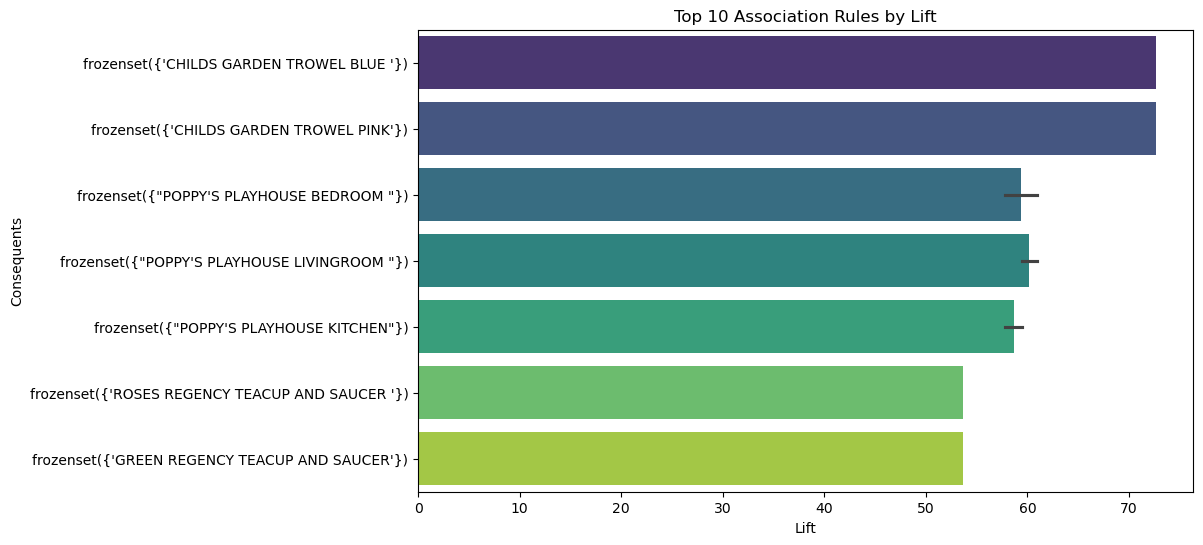

In [ ]:
basket = data_copy.groupby(['InvoiceNo', 'Description'])['Quantity'].sum().unstack().reset_index().fillna(0).set_index('InvoiceNo')

# binarize data
basket = basket.applymap(lambda x: 1 if x > 0 else 0)

# apriori applied
frequent_itemsets = apriori(basket, min_support=0.01, use_colnames=True)

# generate rules
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1)
rules = rules.sort_values('lift', ascending=False)

print("Top 10 association rules:\n", rules.head(10))
plt.figure(figsize=(10, 6))
sns.barplot(x='lift', y='consequents', data=rules.head(10), palette='viridis')
plt.title('Top 10 Association Rules by Lift')
plt.xlabel('Lift')
plt.ylabel('Consequents')
plt.show()

del basket, frequent_itemsets, rules